In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

import preprocessing_utils as helper

%matplotlib inline

In [14]:
# Directory setup
BASE_DIR = '..'

TFRECORDS_DIR = '../data/mwi_lsms_tfrecords_raw/'
LSMS_CSV_PATH = '../data/mwi_lsms_clusters.csv'

EXPORT_DIR = '../data/mwi_lsms_tfrecords/'

In [15]:
# avg_rad is the nightlights band
BANDS = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS', 'DELTA_TEMP', 'CO']

In [16]:
df_lsms = pd.read_csv(LSMS_CSV_PATH)

# Type conversion to float32
df_lsms['lat'] = df_lsms['lat'].astype(np.float32)
df_lsms['lon'] = df_lsms['lon'].astype(np.float32)
df_lsms['consumption'] = df_lsms['consumption'].astype(np.float32)
df_lsms = df_lsms.sort_values('consumption')

print(df_lsms.dtypes)
display(df_lsms)

country         object
consumption    float32
density          int64
lat            float32
lon            float32
dtype: object


,country,consumption,density,lat,lon
0,mwi,0.215783,1,-15.965693,35.392826
1,mwi,0.226473,1,-16.392511,34.890469
2,mwi,0.245305,1,-16.226334,34.824940
3,mwi,0.249300,1,-17.095150,35.217213
4,mwi,0.256492,1,-14.846169,35.500092
...,...,...,...,...,...
12439,mwi,79.715355,0,-14.023146,33.749996
12440,mwi,99.133415,0,-15.385744,35.347683
12441,mwi,106.256859,0,-15.390320,35.315212
12442,mwi,812.808105,1,-14.082816,34.905701


In [17]:
# Searches for tfrecord by latitude and longitude
# tfrecords = sorted([f for f in os.listdir(EXPORT_DIR) if not f.startswith('.')])
# matched_record = ""

# for tf_r in tfrecords:
#     sample_tfrecord = EXPORT_DIR + tf_r
    
#     feature_set = helper.create_single_feature_set(filename=sample_tfrecord)
#     feature_array = helper.get_feature_array(feature_set=feature_set)
#     lat = np.float32(feature_set['lat'].float_list.value[0])
#     lon = np.float32(feature_set['lon'].float_list.value[0])    
    
#     if ((abs(lat - np.float32(9.346658)) < 1e-8) and (abs(lon - np.float32(42.075893) < 1e-8))):
#         print(f'Matching record found: {tf_r}')
#         matched_record = tf_r
    

# First TFRecord path
sample_tfrecord = TFRECORDS_DIR + 'malawi_00.tfrecord'

# Get feature array of first record
feature_set = helper.create_single_feature_set(filename=sample_tfrecord)
helper.get_feature_array(feature_set=feature_set)

{'NIR': ('float_list', (65025,)),
 'country': ('bytes_list', (1,)),
 'RED': ('float_list', (65025,)),
 'lon': ('float_list', (1,)),
 'LAT': ('float_list', (65025,)),
 'SW_IR1': ('float_list', (65025,)),
 'VIIRS': ('float_list', (65025,)),
 'GREEN': ('float_list', (65025,)),
 'SW_IR2': ('float_list', (65025,)),
 'lat': ('float_list', (1,)),
 'density': ('float_list', (1,)),
 'TEMP': ('float_list', (65025,)),
 'consumption': ('float_list', (1,)),
 'system:index': ('bytes_list', (1,)),
 'DELTA_TEMP': ('float_list', (65025,)),
 'BLUE': ('float_list', (65025,)),
 'CO': ('float_list', (65025,)),
 'LON': ('float_list', (65025,))}

(255, 255, 10)
mwi: -15.965693, 35.392826


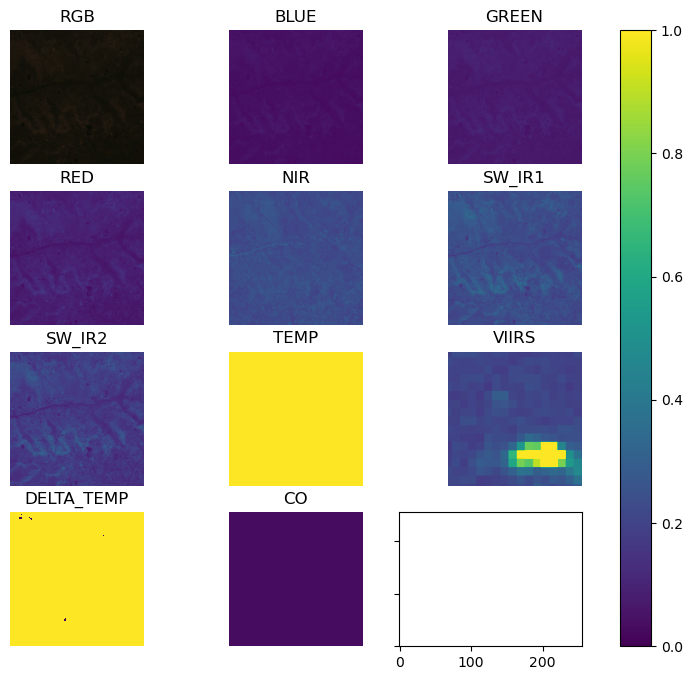

In [19]:
def view_single_record_bands(feature_set):
    lat = np.float32(feature_set['lat'].float_list.value[0])
    lon = np.float32(feature_set['lon'].float_list.value[0])
    country = feature_set['country'].bytes_list.value[0].decode()
    
    band_images = []
    for band_id, band_name in enumerate(BANDS):
        band = np.array(feature_set[band_name].float_list.value, dtype=np.float32).reshape(255, 255)
        band_images.append(band)
    band_images = np.stack(band_images, axis=2)
    print(np.shape(band_images))
    
    print(f'{country}: {lat:4f}, {lon:4f}')
    helper.visualize_bands(img=band_images, band_names=BANDS, bands_per_row=3)
    
    
view_single_record_bands(feature_set=feature_set)

In [20]:
REQUIRED_KEYS = [
    'BLUE', 'GREEN', 'LAT', 'LON', 'VIIRS', 'DELTA_TEMP', 'CO', 'NIR', 'RED', 'SW_IR1', 'SW_IR2', 'TEMP', 'lat',
    'lon', 'consumption', 'density', 'country'
]

def validate_record(feature_set, record_name):
    # Check for missing bands
    missing_req_keys = [key for key in REQUIRED_KEYS if key not in feature_set]
    if len(missing_req_keys) > 0:
        print(f'Record {record_name} missing required keys: {missing_req_keys}')
        return False
    
    lon = np.float32(feature_set['lon'].float_list.value[0])
    lat = np.float32(feature_set['lat'].float_list.value[0])
    
    # Check middle pixel coordinates
    img_lon = np.float32(np.asarray(feature_set['LON'].float_list.value).reshape(255, 255)[127, 127])
    img_lat = np.float32(np.asarray(feature_set['LAT'].float_list.value).reshape(255, 255)[127, 127])

    if abs(lon - img_lon) > 1e-3:
        print(f'Record {record_name} contains mismatch: "lon"={lon}, "LON"={img_lon}')
        return False
    if abs(lat - img_lat) > 1e-3:
        print(f'Record {record_name} contains invalid lat. "lat"={lat}, "LAT"={img_lat}')
        return False

def process_tfrecords(tfrecord_path, export_dir):
    # Incorrect sorting, solely for visual purposes
    tfrecords = sorted([f for f in os.listdir(tfrecord_path) if not f.startswith('.')])
    
    num_good_records = 0
    for tf_i, tf_r in enumerate(tfrecords):
        filename = tfrecord_path + tf_r
        dataset = tf.data.TFRecordDataset(filenames=[filename])
        
        # Splits each TFRecord file into seperate record files
        for record_i, record in enumerate(iter(dataset)):
            example = tf.train.Example.FromString(record.numpy())
            feature_set = example.features.feature
            
            # CHANGE record name as needed
            record_name = f'malawi_{tf_i}_{record_i}'
            is_good_record = validate_record(feature_set=feature_set, record_name=record_name)
            
            if is_good_record != False:    
                # Seralize contents of processed record and write
                os.makedirs(export_dir, exist_ok=True)
                export_path = export_dir + f'/{record_name}' + '.tfrecord'
                
                with tf.io.TFRecordWriter(export_path) as writer:
                    writer.write(example.SerializeToString())
                num_good_records += 1
            
            if (record_i + 1) % 25 == 0:
                print(f'Finished validating {record_i + 1} records')
        
        print(f'Finished validating TFRecord {tf_i + 1}')


In [21]:
process_tfrecords(tfrecord_path=TFRECORDS_DIR, export_dir=EXPORT_DIR)

Record malawi_0_1 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_0_4 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_0_6 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_0_7 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_0_11 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_0_17 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 1
Record malawi_1_5 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_1_12 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_1_16 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_1_18 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_1_20 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 2
Record malawi_2_11 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_2_12 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_2_16 missing required 

Record malawi_18_22 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_18_24 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 19
Record malawi_19_6 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_19_8 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_19_9 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_19_13 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_19_21 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_19_24 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 20
Record malawi_20_18 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_20_19 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_20_20 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 21
Record malawi_21_9 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_21_19 mis

Record malawi_39_11 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_39_14 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_39_18 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_39_19 missing required keys: ['DELTA_TEMP']
Finished validating 25 records
Finished validating TFRecord 40
Record malawi_40_1 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_40_2 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_40_5 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_40_11 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_40_12 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_40_14 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_40_17 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_40_19 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_40_24 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 41
Record malawi_41_6 missing 

Record malawi_57_15 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_57_16 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_57_23 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 58
Record malawi_58_5 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_58_9 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_58_16 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_58_19 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_58_20 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 59
Finished validating 25 records
Finished validating TFRecord 60
Record malawi_60_2 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_60_9 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_60_14 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_60_15 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_60_16 mis

Record malawi_77_7 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_77_16 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_77_18 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_77_21 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 78
Record malawi_78_2 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_78_3 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_78_12 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_78_13 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_78_20 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 79
Record malawi_79_1 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_79_8 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_79_15 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_79_20 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_79_23 m

Record malawi_100_3 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_100_13 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_100_14 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_100_18 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_100_19 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_100_22 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 101
Record malawi_101_6 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_101_16 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_101_24 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 102
Record malawi_102_1 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_102_10 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_102_18 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_102_23 missing required keys: ['DELTA_TEMP', 'TEMP']
Fini

Record malawi_122_5 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_122_7 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_122_14 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_122_19 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_122_21 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_122_22 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 123
Record malawi_123_0 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_123_3 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_123_10 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_123_14 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_123_17 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_123_20 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_123_24 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 124
Recor

Record malawi_140_7 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_140_19 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_140_20 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_140_21 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_140_24 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 141
Record malawi_141_2 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_141_5 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_141_10 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_141_14 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_141_24 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 142
Record malawi_142_6 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_142_19 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_142_21 missing required keys: ['DELTA_TEMP', 'TEMP']
Recor

Record malawi_161_10 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_161_11 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_161_14 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_161_16 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_161_20 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 162
Record malawi_162_2 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_162_20 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 163
Record malawi_163_1 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_163_2 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_163_3 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_163_4 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_163_6 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_163_19 missing required keys: ['DELTA_TEMP', 'TEMP']
Record 

Record malawi_182_22 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 183
Record malawi_183_8 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_183_10 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_183_23 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_183_24 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 184
Record malawi_184_0 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_184_6 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_184_7 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_184_9 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_184_20 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 185
Record malawi_185_7 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_185_8 missing required keys: ['DELTA_TEMP', 'TEMP']
Record mala

Record malawi_201_9 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_201_11 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_201_16 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_201_20 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_201_23 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 202
Record malawi_202_2 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_202_4 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_202_9 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_202_15 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_202_16 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 203
Record malawi_203_0 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_203_15 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_203_18 missing required keys: ['DELTA_TEMP', 'TEMP']
Record

Finished validating 25 records
Finished validating TFRecord 221
Record malawi_221_5 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 222
Record malawi_222_4 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_222_9 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_222_13 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_222_15 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_222_21 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_222_24 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 223
Record malawi_223_2 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_223_10 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_223_13 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_223_21 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 224
Record mala

Record malawi_240_11 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_240_23 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 241
Record malawi_241_2 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_241_4 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_241_11 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_241_16 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_241_18 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_241_21 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 242
Record malawi_242_1 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_242_6 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_242_10 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_242_11 missing required keys: ['DELTA_TEMP', 'TEMP']
Record malawi_242_12 missing required keys: ['DELTA_TEMP', 'TEMP']
Recor